# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [4]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [11]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [12]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 128)                  1152      ['input_2[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 128)                  16512     ['dense_3[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 64)                   8256      ['dense_4[0][0]']             
                                                                                            

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [13]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [14]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 2s 12ms/step - loss: 252.4111 - y1_output_loss: 123.8111 - y2_output_loss: 128.6000 - y1_output_root_mean_squared_error: 11.1270 - y2_output_root_mean_squared_error: 11.3402 - val_loss: 115.3801 - val_y1_output_loss: 27.0934 - val_y2_output_loss: 88.2868 - val_y1_output_root_mean_squared_error: 5.2051 - val_y2_output_root_mean_squared_error: 9.3961
Epoch 2/500
62/62 [==============================] - 0s 4ms/step - loss: 31.6899 - y1_output_loss: 12.1775 - y2_output_loss: 19.5124 - y1_output_root_mean_squared_error: 3.4896 - y2_output_root_mean_squared_error: 4.4173 - val_loss: 114.1125 - val_y1_output_loss: 27.0701 - val_y2_output_loss: 87.0424 - val_y1_output_root_mean_squared_error: 5.2029 - val_y2_output_root_mean_squared_error: 9.3297
Epoch 3/500
62/62 [==============================] - 0s 4ms/step - loss: 27.5474 - y1_output_loss: 10.8443 - y2_output_loss: 16.7031 - y1_output_root_mean_squared_error: 3.2931 - y2_output_root_mean

## Evaluate the Model and Plot Metrics

In [15]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 1.9598 - y1_output_loss: 0.6771 - y2_output_loss: 1.2828 - y1_output_root_mean_squared_error: 0.8229 - y2_output_root_mean_squared_error: 1.1326
Loss = 1.9598444700241089, Y1_loss = 0.6770857572555542, Y1_mse = 0.8228522539138794, Y2_loss = 1.2827585935592651, Y2_mse = 1.132589340209961


5/5 [==============================] - 0s 1ms/step


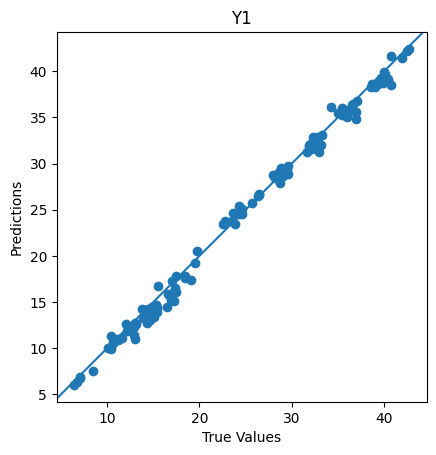

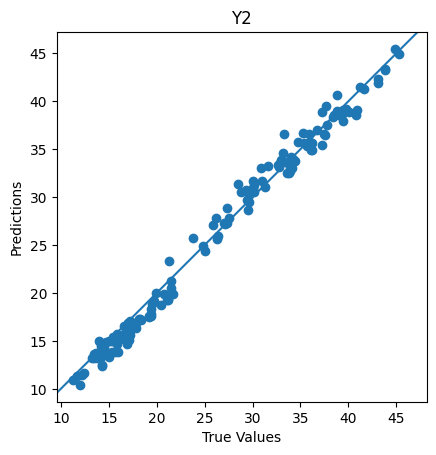

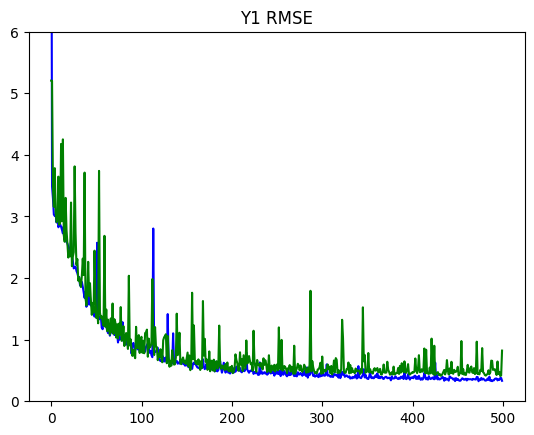

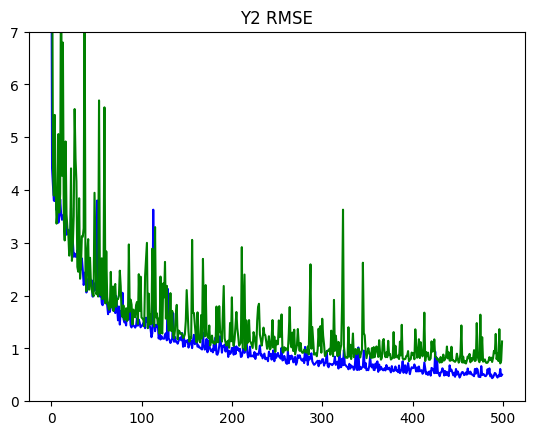

In [16]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)